In [1]:
using LinearAlgebra
using PyPlot
using RobotDynamics
using RobotZoo
using ForwardDiff

In [2]:
# Acrobot Dynamics
@show rbt = RobotZoo.Acrobot()
h = 0.02

rbt = RobotZoo.Acrobot() = RobotZoo.Acrobot{Float64}
  l: StaticArrays.SArray{Tuple{2},Float64,1,2}
  m: StaticArrays.SArray{Tuple{2},Float64,1,2}
  J: StaticArrays.SArray{Tuple{2},Float64,1,2}



0.02

In [3]:
function dynamics_rk45(x, u)
    k1 = dynamics(rbt, x, u)
    k2 = dynamics(rbt, x + 0.5 * h * k1, u)
    k3 = dynamics(rbt, x + 0.5 * h * k2, u)
    k4 = dynamics(rbt, x +       h * k3, u)
    return x + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
end

dynamics_rk45 (generic function with 1 method)

In [4]:
x0 = [-pi/2; 0; 0; 0]
xgoal = [pi/2; 0; 0; 0]
umax = 20
Nx = length(x0)
Nu = 1
Tf = 5.0
@show Nt = Int(Tf / h) + 1
thist = Array(range(0, Tf, step = h));

Nt = Int(Tf / h) + 1 = 251


In [5]:
# Cost Weights
@show Q = Array(1.0 * I(Nx))
@show R = 0.1
@show Qf = Array(500 * I(Nx))

Q = Array(1.0 * I(Nx)) = [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0]
R = 0.1 = 0.1
Qf = Array(500 * I(Nx)) = [500 0 0 0; 0 500 0 0; 0 0 500 0; 0 0 0 500]


4×4 Array{Int64,2}:
 500    0    0    0
   0  500    0    0
   0    0  500    0
   0    0    0  500

In [6]:
function l_cost(x, u)
    return 0.5 * (x - xgoal)' * Q * (x - xgoal) * h +0.5 * u * R * u * h
end

l_cost (generic function with 1 method)

In [7]:
function lf_cost(xf)
    return 0.5 * (xf - xgoal)' * Qf * (xf - xgoal)
end

lf_cost (generic function with 1 method)

In [8]:
function cost(xtraj, utraj)
    # compute the total trajectory cost
    cst = lf_cost(xtraj[:,end])
    for i=1:(Nt-1)
        cst = cst + l_cost(xtraj[:,i], utraj[i])
    end
    return cst
end

cost (generic function with 1 method)

In [9]:
function squash(u)
    # deal with control limitation
    return umax * tanh(1.5*u/umax)
end

squash (generic function with 1 method)

In [10]:
# initialize the trajectories
xtraj = kron(ones(1,Nt), x0)
utraj = 0.0 * randn(Nt-1);

In [11]:
# do initial rollout
for k=1:(Nt-1)
    xtraj[:, k+1] = dynamics_rk45(xtraj[:, k], utraj[k])
end
J = cost(xtraj, utraj)

2492.0751112750695

In [12]:
# DDP Algorithm
Vx = zeros(Nx, Nt)
Vxx = zeros(Nx, Nx, Nt)
du = zeros(Nt-1)
K = zeros(Nu, Nx, Nt-1)

Qx = zeros(Nx, 1)
Qu = 0.0

Qxx = zeros(Nx, Nx)
Quu = .0
Qxu = zeros(Nx, Nu)
Qux = zeros(Nu, Nx)

1×4 Array{Float64,2}:
 0.0  0.0  0.0  0.0

In [13]:
Iter = 0
Max_Iter = 500
for i=1:Max_Iter
    Iter = Iter + 1

    Vx = zeros(Nx, Nt)
    Vxx = zeros(Nx, Nx, Nt)
    du = zeros(Nt-1)
    K = zeros(Nu, Nx, Nt-1)
    ΔJ = 0.0
    
    Vx[:,Nt] = Qf * (xtraj[:, Nt] - xgoal)
    Vxx[:,:,Nt] = Qf
    
    ###############################Backward###############################
    for k=(Nt-1):-1:1
        lx = Q * (xtraj[:, k] - xgoal) * h
        lxx = Q * h
        lu = R * utraj[k] * h
        luu = R * h
        
        A = ForwardDiff.jacobian(dx->dynamics_rk45(dx, utraj[k]), xtraj[:,k])
        B = ForwardDiff.derivative(du->dynamics_rk45(xtraj[:,k], du), utraj[k])
        
        Qx = lx + A' * Vx[:, k+1]
        Qu = lu + B' * Vx[:, k+1]
        
        Qxx = lxx + A' * Vxx[:,:, k+1] * A
        Quu = luu + B' * Vxx[:,:, k+1] * B
        
        Qxu = A' * Vxx[:,:, k+1] * B
        Qux = B' * Vxx[:,:, k+1] * A
        
        du[k] = -Quu \ Qu
        K[:, :, k] = -Quu \ Qux
        
        Vx[:, k] = Qx + K[:,:,k]'*Qu + K[:,:,k]'*Quu*du[k] + Qxu*du[k]
        Vxx[:,:,k] = Qxx + K[:,:,k]'*Quu*K[:,:,k] + Qxu*K[:,:,k] + K[:,:,k]'*Qux
        
        ΔJ = ΔJ + 0.5 * du[k]' * Quu * du[k] + du[k]' * Qu
    end
    
    display("Iter: $Iter || J: $J || ΔJ: $ΔJ")
    
    ################################Forward#####################################
    xnew = zeros(Nx, Nt)
    unew = zeros(Nt-1)
    xnew[:,1] = xtraj[:,1]
    α = 1.0
    for j = 1:(Nt-1)
        unew[j] = utraj[j] + α * du[j] + dot(K[:,:,j], (xnew[:,j]-xtraj[:,j]))
        xnew[:,j+1] = dynamics_rk45(xnew[:,j],unew[j])      
    end
    
    Jnew = cost(xnew, unew)
    
    while Jnew > (J - 1e-2*α*ΔJ)
        α = 0.8 * α
        for j = 1:(Nt-1)
            unew[j] = utraj[j] + α * du[j] + dot(K[:,:,j], (xnew[:,j]-xtraj[:,j]))
            xnew[:,j+1] = dynamics_rk45(xnew[:,j],unew[j])      
        end
        Jnew = cost(xnew, unew)
    end
    J = Jnew
    xtraj .= xnew
    utraj .= unew
    display("α : $α")
    if maximum(abs.(du[:])) < 1e-4
        break
    end
end

"Iter: 1 || J: 2492.0751112750695 || ΔJ: -1947.071688684706"

"α : 0.32768000000000014"

"Iter: 2 || J: 1316.9568794867253 || ΔJ: -1133.367945214991"

"α : 0.32768000000000014"

"Iter: 3 || J: 777.5169776496556 || ΔJ: -636.516312676729"

"α : 0.6400000000000001"

"Iter: 4 || J: 379.931907827601 || ΔJ: -291.63243039592584"

"α : 1.0"

"Iter: 5 || J: 233.1614433100498 || ΔJ: -124.97962879202744"

"α : 1.0"

"Iter: 6 || J: 173.63892420734052 || ΔJ: -84.09232051954412"

"α : 1.0"

"Iter: 7 || J: 114.53797077348764 || ΔJ: -27.07815975399922"

"α : 0.6400000000000001"

"Iter: 8 || J: 110.09358897943989 || ΔJ: -23.412548565263396"

"α : 1.0"

"Iter: 9 || J: 87.43589675118695 || ΔJ: -6.4775893017495125"

"α : 1.0"

"Iter: 10 || J: 79.5790320208678 || ΔJ: -1.6840435103132314"

"α : 1.0"

"Iter: 11 || J: 76.93050509177503 || ΔJ: -0.8823872565148648"

"α : 1.0"

"Iter: 12 || J: 75.43969323130109 || ΔJ: -0.6043544630131927"

"α : 1.0"

"Iter: 13 || J: 74.39134681476466 || ΔJ: -0.41245678718255907"

"α : 1.0"

"Iter: 14 || J: 73.6485181791926 || ΔJ: -0.31034231448326927"

"α : 1.0"

"Iter: 15 || J: 73.07871692560556 || ΔJ: -0.2402289672825875"

"α : 1.0"

"Iter: 16 || J: 72.63011985424453 || ΔJ: -0.19287589983196898"

"α : 1.0"

"Iter: 17 || J: 72.26558254118544 || ΔJ: -0.15822317429349364"

"α : 1.0"

"Iter: 18 || J: 71.96378643372337 || ΔJ: -0.13220685940000082"

"α : 1.0"

"Iter: 19 || J: 71.70977881663842 || ΔJ: -0.11200534526621095"

"α : 1.0"

"Iter: 20 || J: 71.49342102394388 || ΔJ: -0.09591857609713075"

"α : 1.0"

"Iter: 21 || J: 71.30732010495363 || ΔJ: -0.08286729206116734"

"α : 1.0"

"Iter: 22 || J: 71.14601077330816 || ΔJ: -0.07207825410841608"

"α : 1.0"

"Iter: 23 || J: 71.00532387485671 || ΔJ: -0.06305053719559871"

"α : 1.0"

"Iter: 24 || J: 70.88200741456508 || ΔJ: -0.055397126416299396"

"α : 1.0"

"Iter: 25 || J: 70.77348095393204 || ΔJ: -0.04885401018986349"

"α : 1.0"

"Iter: 26 || J: 70.67765476131117 || ΔJ: -0.043209764318110265"

"α : 1.0"

"Iter: 27 || J: 70.59281701038971 || ΔJ: -0.03831186089180049"

"α : 1.0"

"Iter: 28 || J: 70.51754251997241 || ΔJ: -0.03403557513098355"

"α : 1.0"

"Iter: 29 || J: 70.4506345846831 || ΔJ: -0.03028624659282867"

"α : 1.0"

"Iter: 30 || J: 70.39107609231719 || ΔJ: -0.026985243060166506"

"α : 1.0"

"Iter: 31 || J: 70.3379968688531 || ΔJ: -0.024070301855230236"

"α : 1.0"

"Iter: 32 || J: 70.29064590114412 || ΔJ: -0.02148897865018136"

"α : 1.0"

"Iter: 33 || J: 70.24837174305881 || ΔJ: -0.019198324100659324"

"α : 1.0"

"Iter: 34 || J: 70.21060580114711 || ΔJ: -0.01716169787613674"

"α : 1.0"

"Iter: 35 || J: 70.17684990857482 || ΔJ: -0.015348309363282098"

"α : 1.0"

"Iter: 36 || J: 70.1466657083954 || ΔJ: -0.013731591391926081"

"α : 1.0"

"Iter: 37 || J: 70.11966638914727 || ΔJ: -0.01228878570778596"

"α : 1.0"

"Iter: 38 || J: 70.09550960001624 || ΔJ: -0.011000065642237761"

"α : 1.0"

"Iter: 39 || J: 70.07389172388852 || ΔJ: -0.009848208030287945"

"α : 1.0"

"Iter: 40 || J: 70.05454294107481 || ΔJ: -0.008818090460920433"

"α : 1.0"

"Iter: 41 || J: 70.03722312005938 || ΔJ: -0.007896444095603463"

"α : 1.0"

"Iter: 42 || J: 70.02171825198451 || ΔJ: -0.007071547138244448"

"α : 1.0"

"Iter: 43 || J: 70.00783741624025 || ΔJ: -0.0063330414377906815"

"α : 1.0"

"Iter: 44 || J: 69.99541012953239 || ΔJ: -0.005671734165814984"

"α : 1.0"

"Iter: 45 || J: 69.98428405318259 || ΔJ: -0.005079461581729873"

"α : 1.0"

"Iter: 46 || J: 69.97432297759201 || ΔJ: -0.00454895375414852"

"α : 1.0"

"Iter: 47 || J: 69.96540505889492 || ΔJ: -0.004073732422874587"

"α : 1.0"

"Iter: 48 || J: 69.95742126053895 || ΔJ: -0.0036480145634132845"

"α : 1.0"

"Iter: 49 || J: 69.95027397877841 || ΔJ: -0.0032666348545626767"

"α : 1.0"

"Iter: 50 || J: 69.94387582274523 || ΔJ: -0.0029249744963438453"

"α : 1.0"

"Iter: 51 || J: 69.93814853242192 || ΔJ: -0.0026189015973430763"

"α : 1.0"

"Iter: 52 || J: 69.93302201518144 || ΔJ: -0.0023447172289217783"

"α : 1.0"

"Iter: 53 || J: 69.92843348793487 || ΔJ: -0.0020991090544544995"

"α : 1.0"

"Iter: 54 || J: 69.92432671145775 || ΔJ: -0.0018791096474186704"

"α : 1.0"

"Iter: 55 || J: 69.920651306858 || ΔJ: -0.0016820600670368747"

"α : 1.0"

"Iter: 56 || J: 69.91736214445928 || ΔJ: -0.001505577202615977"

"α : 1.0"

"Iter: 57 || J: 69.91441879729442 || ΔJ: -0.0013475249395040617"

"α : 1.0"

"Iter: 58 || J: 69.91178505192964 || ΔJ: -0.0012059883245960487"

"α : 1.0"

"Iter: 59 || J: 69.90942847051772 || ΔJ: -0.0010792506063678538"

"α : 1.0"

"Iter: 60 || J: 69.90731999849444 || ΔJ: -0.00096577265897922"

"α : 1.0"

"Iter: 61 || J: 69.90543361311629 || ΔJ: -0.0008641746213798995"

"α : 1.0"

"Iter: 62 || J: 69.90374600848426 || ΔJ: -0.0007732194351771189"

"α : 1.0"

"Iter: 63 || J: 69.90223631324648 || ΔJ: -0.0006917981177441735"

"α : 1.0"

"Iter: 64 || J: 69.90088583754483 || ΔJ: -0.0006189165522303149"

"α : 1.0"

"Iter: 65 || J: 69.89967784617548 || ΔJ: -0.0005536836520625474"

"α : 1.0"

"Iter: 66 || J: 69.89859735522882 || ΔJ: -0.0004953007409417181"

"α : 1.0"

"Iter: 67 || J: 69.89763094978584 || ΔJ: -0.0004430520294868725"

"α : 1.0"

"Iter: 68 || J: 69.89676662049024 || ΔJ: -0.0003962960682691278"

"α : 1.0"

"Iter: 69 || J: 69.89599361704752 || ΔJ: -0.0003544580798878485"

"α : 1.0"

"Iter: 70 || J: 69.89530231690506 || ΔJ: -0.0003170230767835134"

"α : 1.0"

"Iter: 71 || J: 69.89468410754579 || ΔJ: -0.0002835296857135868"

"α : 1.0"

"Iter: 72 || J: 69.89413128099547 || ΔJ: -0.0002535646052855954"

"α : 1.0"

"Iter: 73 || J: 69.89363693928 || ΔJ: -0.0002267576325359307"

"α : 1.0"

"Iter: 74 || J: 69.89319490970465 || ΔJ: -0.00020277719990240064"

"α : 1.0"

"Iter: 75 || J: 69.89279966894274 || ΔJ: -0.00018132637082742513"

"α : 1.0"

"Iter: 76 || J: 69.89244627502285 || ΔJ: -0.00016213924696597"

"α : 1.0"

"Iter: 77 || J: 69.89213030639836 || ΔJ: -0.00014497774515560285"

"α : 1.0"

"Iter: 78 || J: 69.89184780736714 || ΔJ: -0.0001296287063148714"

"α : 1.0"

"Iter: 79 || J: 69.89159523918467 || ΔJ: -0.000115901302445281"

"α : 1.0"

"Iter: 80 || J: 69.8913694362804 || ΔJ: -0.0001036247112366582"

"α : 1.0"

"Iter: 81 || J: 69.8911675670478 || ΔJ: -9.264603094430102e-5"

"α : 1.0"

"Iter: 82 || J: 69.89098709873375 || ΔJ: -8.282841092314835e-5"

"α : 1.0"

"Iter: 83 || J: 69.89082576600289 || ΔJ: -7.404937573886471e-5"

"α : 1.0"

"Iter: 84 || J: 69.89068154279143 || ΔJ: -6.619932298832227e-5"

"α : 1.0"

"Iter: 85 || J: 69.8905526171127 || ΔJ: -5.918017699746587e-5"

"α : 1.0"

"Iter: 86 || J: 69.8904373685019 || ΔJ: -5.2904182364276404e-5"

"α : 1.0"

"Iter: 87 || J: 69.89033434782995 || ΔJ: -4.7292822952510514e-5"

"α : 1.0"

"Iter: 88 || J: 69.89024225923505 || ΔJ: -4.227585340153271e-5"

"α : 1.0"

"Iter: 89 || J: 69.89015994395349 || ΔJ: -3.779043154360481e-5"

"α : 1.0"

"Iter: 90 || J: 69.89008636584951 || ΔJ: -3.3780341297875803e-5"

"α : 1.0"

"Iter: 91 || J: 69.89002059846825 || ΔJ: -3.0195296682010784e-5"

"α : 1.0"

"Iter: 92 || J: 69.88996181345006 || ΔJ: -2.6990318538103877e-5"

"α : 1.0"

"Iter: 93 || J: 69.88990927016582 || ΔJ: -2.4125176431735683e-5"

"α : 1.0"

"Iter: 94 || J: 69.88986230644359 || ΔJ: -2.1563888958263666e-5"

"α : 1.0"

"Iter: 95 || J: 69.88982033027291 || ΔJ: -1.9274276384523648e-5"

"α : 1.0"

"Iter: 96 || J: 69.8897828123839 || ΔJ: -1.722756018028936e-5"

"α : 1.0"

"Iter: 97 || J: 69.88974927960956 || ΔJ: -1.5398004556757502e-5"

"α : 1.0"

"Iter: 98 || J: 69.88971930894778 || ΔJ: -1.3762595630242463e-5"

"α : 1.0"

"Iter: 99 || J: 69.88969252225161 || ΔJ: -1.2300754285968924e-5"

"α : 1.0"

"Iter: 100 || J: 69.88966858147919 || ΔJ: -1.0994079220207251e-5"

"α : 1.0"

"Iter: 101 || J: 69.88964718444652 || ΔJ: -9.826117006530147e-6"

"α : 1.0"

"Iter: 102 || J: 69.8896280610283 || ΔJ: -8.782156357599418e-6"

"α : 1.0"

"Iter: 103 || J: 69.88961096976169 || ΔJ: -7.849044048628323e-6"

"α : 1.0"

"Iter: 104 || J: 69.88959569480757 || ΔJ: -7.0150202321736946e-6"

"α : 1.0"

"Iter: 105 || J: 69.8895820432356 || ΔJ: -6.26957111018427e-6"

"α : 1.0"

"Iter: 106 || J: 69.88956984259391 || ΔJ: -5.603297141468946e-6"

"α : 1.0"

"Iter: 107 || J: 69.88955893873883 || ΔJ: -5.007795152755031e-6"

"α : 1.0"

"Iter: 108 || J: 69.88954919389244 || ΔJ: -4.475552891686981e-6"

"α : 1.0"

"Iter: 109 || J: 69.88954048490635 || ΔJ: -3.999854714079548e-6"

"α : 1.0"

"Iter: 110 || J: 69.88953270170981 || ΔJ: -3.574697232509366e-6"

"α : 1.0"

"Iter: 111 || J: 69.8895257459226 || ΔJ: -3.1947138785490445e-6"

"α : 1.0"

"Iter: 112 || J: 69.88951952961337 || ΔJ: -2.855107438821061e-6"

"α : 1.0"

"Iter: 113 || J: 69.88951397419119 || ΔJ: -2.551589724729399e-6"

"α : 1.0"

"Iter: 114 || J: 69.88950900941424 || ΔJ: -2.2803276236619096e-6"

"α : 1.0"

"Iter: 115 || J: 69.88950457250301 || ΔJ: -2.0378948581578312e-6"

"α : 1.0"

"Iter: 116 || J: 69.88950060734818 || ΔJ: -1.8212288508440413e-6"

"α : 1.0"

"Iter: 117 || J: 69.8894970638021 || ΔJ: -1.6275921556987119e-6"

"α : 1.0"

"Iter: 118 || J: 69.88949389704634 || ΔJ: -1.454537973770801e-6"

"α : 1.0"

"Iter: 119 || J: 69.88949106702502 || ΔJ: -1.299879321044925e-6"

"α : 1.0"

"Iter: 120 || J: 69.88948853793902 || ΔJ: -1.1616614632342803e-6"

"α : 1.0"

"Iter: 121 || J: 69.8894862777941 || ΔJ: -1.0381372711220831e-6"

"α : 1.0"

"Iter: 122 || J: 69.88948425799653 || ΔJ: -9.277451883376797e-7"

"α : 1.0"

"Iter: 123 || J: 69.88948245299204 || ΔJ: -8.290895345186138e-7"

"α : 1.0"

"Iter: 124 || J: 69.88948083994225 || ΔJ: -7.40922897111408e-7"

"α : 1.0"

"Iter: 125 || J: 69.88947939843705 || ΔJ: -6.621303904352837e-7"

"α : 1.0"

"Iter: 126 || J: 69.88947811023543 || ΔJ: -5.917155843031624e-7"

"α : 1.0"

"Iter: 127 || J: 69.88947695903605 || ΔJ: -5.287879254669677e-7"

"α : 1.0"

"Iter: 128 || J: 69.88947593027044 || ΔJ: -4.725514936120124e-7"

"α : 1.0"

"Iter: 129 || J: 69.88947501091887 || ΔJ: -4.2229495051173407e-7"

"α : 1.0"

"Iter: 130 || J: 69.88947418934625 || ΔJ: -3.7738255585039293e-7"

"α : 1.0"

"Iter: 131 || J: 69.88947345515406 || ΔJ: -3.3724613672603275e-7"

"α : 1.0"

"Iter: 132 || J: 69.88947279904994 || ΔJ: -3.013779095857886e-7"

"α : 1.0"

"Iter: 133 || J: 69.88947221272916 || ΔJ: -2.693240642336472e-7"

"α : 1.0"

"Iter: 134 || J: 69.88947168877039 || ΔJ: -2.40679029136502e-7"

"α : 1.0"

"Iter: 135 || J: 69.88947122054113 || ΔJ: -2.15080345695669e-7"

"α : 1.0"

"Iter: 136 || J: 69.88947080211457 || ΔJ: -1.9220408682751073e-7"

"α : 1.0"

"Iter: 137 || J: 69.88947042819393 || ΔJ: -1.7176076216738942e-7"

"α : 1.0"

"Iter: 138 || J: 69.88947009404546 || ΔJ: -1.5349165828345075e-7"

"α : 1.0"

"Iter: 139 || J: 69.88946979543917 || ΔJ: -1.3716556757275345e-7"

"α : 1.0"

"Iter: 140 || J: 69.88946952859496 || ΔJ: -1.2257586471879976e-7"

"α : 1.0"

"Iter: 141 || J: 69.88946929013453 || ΔJ: -1.0953789377411092e-7"

"α : 1.0"

"Iter: 142 || J: 69.88946907703888 || ΔJ: -9.788663282966694e-8"

"α : 1.0"

"Iter: 143 || J: 69.88946888661006 || ΔJ: -8.747460688759964e-8"

"α : 1.0"

"Iter: 144 || J: 69.88946871643736 || ΔJ: -7.817002248713813e-8"

"α : 1.0"

"Iter: 145 || J: 69.88946856436596 || ΔJ: -6.985510057279665e-8"

"α : 1.0"

"Iter: 146 || J: 69.88946842847074 || ΔJ: -6.242458657539168e-8"

"α : 1.0"

"Iter: 147 || J: 69.88946830703105 || ΔJ: -5.578441878794306e-8"

"α : 1.0"

"Iter: 148 || J: 69.88946819850919 || ΔJ: -4.9850538360414106e-8"

"α : 1.0"

"Iter: 149 || J: 69.88946810153111 || ΔJ: -4.454782570437381e-8"

"α : 1.0"

"Iter: 150 || J: 69.88946801486897 || ΔJ: -3.980915000784373e-8"

"α : 1.0"

"Iter: 151 || J: 69.88946793742555 || ΔJ: -3.55745197821121e-8"

"α : 1.0"

"Iter: 152 || J: 69.88946786822012 || ΔJ: -3.179032370222192e-8"

"α : 1.0"

"Iter: 153 || J: 69.88946780637629 || ΔJ: -2.8408652157107156e-8"

"α : 1.0"

"Iter: 154 || J: 69.8894677511113 || ΔJ: -2.5386690930488107e-8"

"α : 1.0"

"Iter: 155 || J: 69.88946770172508 || ΔJ: -2.2686179365841705e-8"

"α : 1.0"

"Iter: 156 || J: 69.88946765759228 || ΔJ: -2.027292610129892e-8"

"α : 1.0"

"Iter: 157 || J: 69.8894676181543 || ΔJ: -1.8116376324997276e-8"

"α : 1.0"

"Iter: 158 || J: 69.88946758291164 || ΔJ: -1.618922504107392e-8"

"α : 1.0"

"Iter: 159 || J: 69.8894675514179 || ΔJ: -1.446707144305237e-8"

"α : 1.0"

"Iter: 160 || J: 69.88946752327448 || ΔJ: -1.292811005625994e-8"

"α : 1.0"

"Iter: 161 || J: 69.88946749812483 || ΔJ: -1.1552854706725314e-8"

"α : 1.0"

"Iter: 162 || J: 69.88946747565063 || ΔJ: -1.0323891862813122e-8"

"α : 1.0"

"Iter: 163 || J: 69.889467455567 || ΔJ: -9.225660190287783e-9"

"α : 1.0"

"Iter: 164 || J: 69.88946743761996 || ΔJ: -8.244253554453325e-9"

"α : 1.0"

"Iter: 165 || J: 69.88946742158208 || ΔJ: -7.367244982011006e-9"

"α : 1.0"

"Iter: 166 || J: 69.88946740725034 || ΔJ: -6.58352933252557e-9"

"α : 1.0"

"Iter: 167 || J: 69.88946739444323 || ΔJ: -5.883182704184844e-9"

"α : 1.0"

"Iter: 168 || J: 69.88946738299836 || ΔJ: -5.257336796209995e-9"

"α : 1.0"

"Iter: 169 || J: 69.88946737277111 || ΔJ: -4.698066634146727e-9"

"α : 1.0"

"Iter: 170 || J: 69.88946736363181 || ΔJ: -4.198290230425696e-9"

"α : 1.0"

"Iter: 171 || J: 69.88946735546473 || ΔJ: -3.7516789161943465e-9"

"α : 1.0"

"Iter: 172 || J: 69.88946734816653 || ΔJ: -3.352577219542621e-9"

"α : 1.0"

"Iter: 173 || J: 69.88946734164462 || ΔJ: -2.995931253502974e-9"

"α : 1.0"

"Iter: 174 || J: 69.88946733581652 || ΔJ: -2.6772247332088253e-9"

"α : 1.0"

"Iter: 175 || J: 69.88946733060854 || ΔJ: -2.3924217832047413e-9"

"α : 1.0"

"Iter: 176 || J: 69.88946732595444 || ΔJ: -2.137915843868832e-9"

"α : 1.0"

"Iter: 177 || J: 69.88946732179558 || ΔJ: -1.910484002008815e-9"

"α : 1.0"

"Iter: 178 || J: 69.88946731807904 || ΔJ: -1.7072461802978431e-9"

"α : 1.0"

"Iter: 179 || J: 69.88946731475775 || ΔJ: -1.525628671439857e-9"

"α : 1.0"

"Iter: 180 || J: 69.88946731179003 || ΔJ: -1.3633315482358086e-9"

"α : 1.0"

"Iter: 181 || J: 69.88946730913794 || ΔJ: -1.2182995416815135e-9"

"α : 1.0"

"Iter: 182 || J: 69.88946730676793 || ΔJ: -1.088696014396888e-9"

"α : 1.0"

"Iter: 183 || J: 69.88946730465001 || ΔJ: -9.72879704455063e-10"

"α : 1.0"

"Iter: 184 || J: 69.88946730275745 || ΔJ: -8.693839430760237e-10"

"α : 1.0"

"Iter: 185 || J: 69.88946730106632 || ΔJ: -7.768980812768469e-10"

"α : 1.0"

"Iter: 186 || J: 69.88946729955491 || ΔJ: -6.942508937803252e-10"

"α : 1.0"

"Iter: 187 || J: 69.88946729820428 || ΔJ: -6.203957484918846e-10"

"α : 1.0"

"Iter: 188 || J: 69.88946729699745 || ΔJ: -5.54397351883476e-10"

"α : 1.0"

"Iter: 189 || J: 69.88946729591908 || ΔJ: -4.954199043977643e-10"

"α : 1.0"

"Iter: 190 || J: 69.88946729495525 || ΔJ: -4.4271651962623664e-10"

"α : 1.0"

"Iter: 191 || J: 69.8894672940941 || ΔJ: -3.9561976189918724e-10"

"α : 1.0"

"Iter: 192 || J: 69.88946729332439 || ΔJ: -3.535331980433638e-10"

"α : 1.0"

"Iter: 193 || J: 69.88946729263667 || ΔJ: -3.159238422346409e-10"

"α : 1.0"

"Iter: 194 || J: 69.88946729202213 || ΔJ: -2.8231540772872503e-10"

"α : 1.0"

"Iter: 195 || J: 69.88946729147288 || ΔJ: -2.5228227450805696e-10"

"α : 1.0"

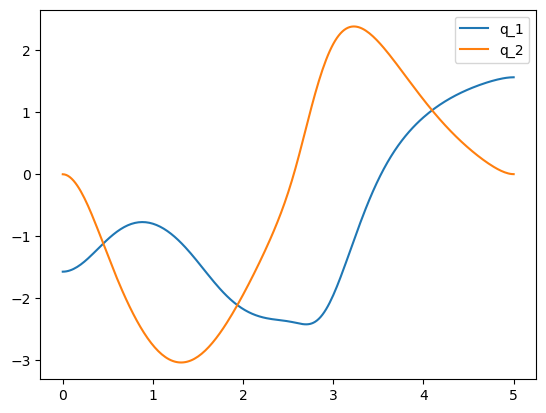

PyObject <matplotlib.legend.Legend object at 0x000000005AEE38B0>

In [14]:
plot(thist,xtraj[1,:],label="q_1")
plot(thist,xtraj[2,:],label="q_2")
legend()

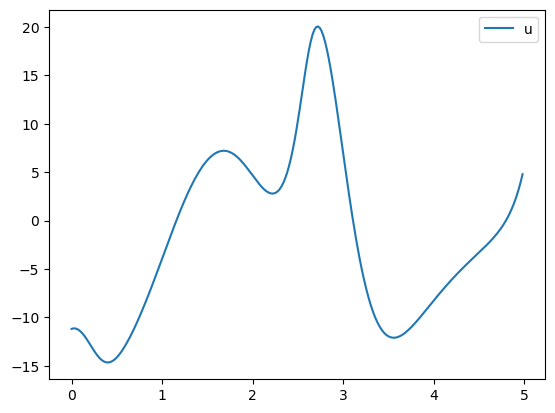

PyObject <matplotlib.legend.Legend object at 0x000000005B8E7D90>

In [15]:
plot(thist[1:end-1], utraj, label="u")
legend()